In [395]:
from numpy import dot
from numpy.linalg import norm
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

In [431]:
data = pd.read_excel('../Data/ИтоговыеДанные.xlsx')

In [488]:
# Группировка данных по клиентам и подсчет общего количества посещений и общего расхода
client_data = data.groupby('ID Клиента').agg({'МАГАЗИН': 'count', 'Сумма расходов': 'sum'})

# Создание вектора для каждого клиента
vectors = []
for client_id, row in client_data.iterrows():
    visits = row['МАГАЗИН']
    spending = row['Сумма расходов']
    vector = [visits, spending]
    vectors.append(vector)

# Преобразование векторов в DataFrame
cluster_vector = pd.DataFrame(vectors, columns=['Shop Attendance', 'Total Spendings'], index=client_data.index)

In [489]:
cluster_vector

,Shop Attendance,Total Spendings
ID Клиента,,
10157447,107,632039
10157454,1,163
10158439,27,635690
10158854,528,15423642
10159585,67,222196
...,...,...
11328050,186,8064333
11328121,13,1653598
11335636,1,884311


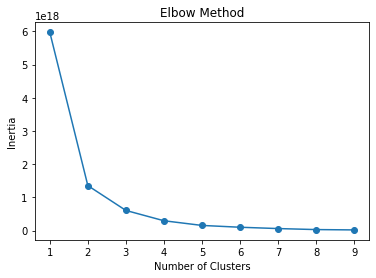

In [486]:
# Группировка данных по клиентам и подсчет общего количества посещений и общего расхода
client_data = cluster_vector.groupby('ID Клиента').agg({'Shop Attendance': 'count', 'Total Spendings': 'sum'})

# Создание вектора для каждого клиента
vectors = client_data[['Shop Attendance', 'Total Spendings']].values

# Преобразование векторов в DataFrame
cluster_vector = pd.DataFrame(vectors, columns=['Shop Attendance', 'Total Spendings'], index=client_data.index)

# Применение метода локтя для определения оптимального числа кластеров
# Задаем список чисел кластеров для проверки
cluster_range = range(1, 10)
inertia = []

# Выполняем KMeans для каждого значения числа кластеров
for num_clusters in cluster_range:
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(cluster_vector)
    inertia.append(kmeans.inertia_)

# Визуализация метода локтя
plt.plot(cluster_range, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()


In [490]:
total_spendings_mean = cluster_vector['Total Spendings'].mean()
shop_attendance_mean = cluster_vector['Shop Attendance'].mean()


def get_spendings(row):
    if row['Total Spendings'] <= total_spendings_mean:
        return 'Low'
    else:
        return 'High'

def get_attendance(row):
    if row['Shop Attendance'] <= shop_attendance_mean + 100:
        return 'Low'
    else:
        return 'High'
    
cluster_vector['SPENDINGS'] = cluster_vector.apply(get_spendings, axis=1)
cluster_vector['ATTENDANCE'] = cluster_vector.apply(get_attendance, axis=1)

In [491]:
cluster_vector

,Shop Attendance,Total Spendings,SPENDINGS,ATTENDANCE
ID Клиента,,,,
10157447,107,632039,Low,Low
10157454,1,163,Low,Low
10158439,27,635690,Low,Low
10158854,528,15423642,High,High
10159585,67,222196,Low,Low
...,...,...,...,...
11328050,186,8064333,Low,Low
11328121,13,1653598,Low,Low
11335636,1,884311,Low,Low


In [466]:
# Создание списков с ID клиентов с высоким и низким показателем INCOME
high_spendings = cluster_vector[cluster_vector['SPENDINGS'] == 'High'].index.tolist()
low_spendings = cluster_vector[cluster_vector['SPENDINGS'] == 'Low'].index.tolist()

# Создание списков с ID клиентов с высоким и низким показателем ATTENDANCE
high_attendance = cluster_vector[cluster_vector['ATTENDANCE'] == 'High'].index.tolist()
low_attendance = cluster_vector[cluster_vector['ATTENDANCE'] == 'Low'].index.tolist()


In [492]:
def find_samplers_(group):
    for i in group:
        # Winsorize the spending data
        spending = data[data['ID Клиента'] == i]['Сумма расходов']
        winsorized_spending = np.clip(spending, spending.quantile(0.05), spending.quantile(0.95))
        
        discount = list(data[data['ID Клиента'] == i]['Предоставленная скидка'].unique())[0]
        n_shops = cluster_vector.loc[i]['Shop Attendance']
        
        if winsorized_spending.mean() > 50000 and discount > 15 and n_shops >= 10:
            print(i)

In [493]:
find_samplers(high_spendings)

10574034
11018820
11127430
11259771
11260095


In [494]:
find_samplers(high_attendance)

11018820
11127430
11259771
11260095


In [495]:
data[data['ID Клиента'] == 11018820.0]

,Unnamed: 0,Торговый день,ID Клиента,Регион проживания,МАГАЗИН,"Тип карточки (B-VISA, S-MASTERCARD или МИР)",Сумма расходов,Предоставленная скидка,Возраст клиента,Цена без скидки
297,297,2020-07-08,11018820,г.Москва,Алкогольный магазин,S,94250,21,21,119303
311,311,2020-07-13,11018820,г.Москва,Не определено,B,50010,21,21,63303
317,317,2020-07-14,11018820,г.Москва,Не определено,B,31780,21,21,40227
318,318,2020-07-14,11018820,г.Москва,"Бар ""Коктейль""",B,35240,21,21,44607
368,368,2020-07-24,11018820,г.Москва,Не определено,S,67950,21,21,86012
...,...,...,...,...,...,...,...,...,...,...
41847,41880,2022-02-25,11018820,г.Москва,"Бар ""Коктейль""",S,49267,21,21,62363
42604,42637,2022-09-02,11018820,г.Москва,"Бар ""Коктейль""",B,164,21,21,207
42631,42664,2022-09-07,11018820,г.Москва,"Бар ""Коктейль""",B,56,21,21,70
42709,42742,2022-09-20,11018820,г.Москва,"Бар ""Коктейль""",B,116,21,21,146


### More Specific Recommendations

In [499]:
# Группировка данных по клиентам и разделение на секторы
# Define the sectors
sectors = {
    'Gastronomic': ['Алкогольный магазин', 'Бар "Иной"', 'Бар "Коктейль"', 'Ресторан "Буйвол"'],
    'Tourism': ['Турагенство'],
    'Shopping': ['Покупка одежды', 'Покупка техники', 'Покупки Ozon'],
    'Auto': ['Такси', 'Автотранспорт'],
    'Beauty': ['Салон красоты', 'Барбершоп'],
    'Other': ['Не определено', 'Перевод денег на депозит']
}

# Initialize a dictionary to store the sector visitation and spending for each client
client_sector_data = {}

# Iterate over each client
for client_id, row in data.groupby('ID Клиента'):
    sector_data = {sector: {'Spendings': 0, 'Visits': 0} for sector in sectors.keys()}

    # Iterate over each transaction of the client
    for _, transaction in row.iterrows():
        for sector, categories in sectors.items():
            if transaction['МАГАЗИН'] in categories:
                sector_data[sector]['Spendings'] += transaction['Сумма расходов']
                sector_data[sector]['Visits'] += 1
                break

    client_sector_data[client_id] = {
        **sector_data
    }

# Convert the client sector data into a DataFrame
client_sector_vector = pd.DataFrame.from_dict(client_sector_data, orient='index')
client_sector_vector = client_sector_vector.fillna(0)


In [555]:
client_sector_vector

,Gastronomic,Tourism,Shopping,Auto,Beauty,Other
10157447,"{'Spendings': 247082, 'Visits': 38}","{'Spendings': 75128, 'Visits': 13}","{'Spendings': 11000, 'Visits': 2}","{'Spendings': 60149, 'Visits': 11}","{'Spendings': 153084, 'Visits': 26}","{'Spendings': 85596, 'Visits': 17}"
10157454,"{'Spendings': 0, 'Visits': 0}","{'Spendings': 0, 'Visits': 0}","{'Spendings': 0, 'Visits': 0}","{'Spendings': 163, 'Visits': 1}","{'Spendings': 0, 'Visits': 0}","{'Spendings': 0, 'Visits': 0}"
10158439,"{'Spendings': 334775, 'Visits': 11}","{'Spendings': 0, 'Visits': 0}","{'Spendings': 17322, 'Visits': 5}","{'Spendings': 0, 'Visits': 0}","{'Spendings': 283593, 'Visits': 11}","{'Spendings': 0, 'Visits': 0}"
10158854,"{'Spendings': 6637925, 'Visits': 200}","{'Spendings': 1748368, 'Visits': 66}","{'Spendings': 822187, 'Visits': 62}","{'Spendings': 2166588, 'Visits': 95}","{'Spendings': 2336393, 'Visits': 61}","{'Spendings': 1712181, 'Visits': 44}"
10159585,"{'Spendings': 13133, 'Visits': 6}","{'Spendings': 112317, 'Visits': 26}","{'Spendings': 33734, 'Visits': 14}","{'Spendings': 13777, 'Visits': 7}","{'Spendings': 20298, 'Visits': 3}","{'Spendings': 28937, 'Visits': 11}"
...,...,...,...,...,...,...
11328050,"{'Spendings': 3288810, 'Visits': 61}","{'Spendings': 433313, 'Visits': 29}","{'Spendings': 1816164, 'Visits': 35}","{'Spendings': 314129, 'Visits': 19}","{'Spendings': 464380, 'Visits': 15}","{'Spendings': 1747537, 'Visits': 27}"
11328121,"{'Spendings': 6464, 'Visits': 2}","{'Spendings': 0, 'Visits': 0}","{'Spendings': 786840, 'Visits': 4}","{'Spendings': 37925, 'Visits': 5}","{'Spendings': 0, 'Visits': 0}","{'Spendings': 822369, 'Visits': 2}"
11335636,"{'Spendings': 0, 'Visits': 0}","{'Spendings': 0, 'Visits': 0}","{'Spendings': 0, 'Visits': 0}","{'Spendings': 0, 'Visits': 0}","{'Spendings': 0, 'Visits': 0}","{'Spendings': 884311, 'Visits': 1}"
11336361,"{'Spendings': 365144, 'Visits': 50}","{'Spendings': 12027, 'Visits': 5}","{'Spendings': 75181, 'Visits': 32}","{'Spendings': 33024, 'Visits': 12}","{'Spendings': 20001, 'Visits': 10}","{'Spendings': 27348, 'Visits': 10}"


In [560]:
id = list(data['ID Клиента'].unique())

def mean_for_sector(sector):
    s = v = 0
    for i in id:
        s += client_sector_vector.loc[i, sector]['Spendings']
        v += client_sector_vector.loc[i, sector]['Visits']
    spendings_mean = s / 743
    visits_mean = v / 743
    print('Sector:', sector)
    print('Spendings mean:', spendings_mean)
    print('Visits mean:', visits_mean)

    # Find clients with above-average Visits, Spendings, and discount > 15
    above_avg_clients = []
    for i in id:
        if client_sector_vector.loc[i, sector]['Spendings'] > spendings_mean and \
                client_sector_vector.loc[i, sector]['Visits'] > visits_mean and \
                data[data['ID Клиента'] == i]['Предоставленная скидка'].max() > 15:
            above_avg_clients.append(i)

    print('Clients with above-average Visits, Spendings, and discount > 15:', above_avg_clients)
    print()

mean_for_sector('Gastronomic')
mean_for_sector('Tourism')
mean_for_sector('Shopping')
mean_for_sector('Auto')
mean_for_sector('Beauty')
mean_for_sector('Other')


Sector: Gastronomic
Spendings mean: 4445112.594885599
Visits mean: 34.899057873485866
Clients with above-average Visits, Spendings, and discount > 15: [11127430, 10355641, 11259771, 11018820, 11260095, 10356174]

Sector: Tourism
Spendings mean: 3143044.802153432
Visits mean: 8.499327052489905
Clients with above-average Visits, Spendings, and discount > 15: [11127430, 10355641, 10562323, 11259771, 11018820, 11260095]

Sector: Shopping
Spendings mean: 609275.7415881561
Visits mean: 8.005383580080753
Clients with above-average Visits, Spendings, and discount > 15: [11127430, 10355641, 11259771, 11018820, 10359664, 10409000, 10830303, 10216655, 10201728]

Sector: Auto
Spendings mean: 1256373.0174966352
Visits mean: 8.947510094212651
Clients with above-average Visits, Spendings, and discount > 15: [11127430, 10355641, 11128132, 11259771, 11018820, 10830303]

Sector: Beauty
Spendings mean: 2935480.1695827725
Visits mean: 15.557200538358009
Clients with above-average Visits, Spendings, and di

In [563]:
data[data['ID Клиента'] == 11259771.0]

,Unnamed: 0,Торговый день,ID Клиента,Регион проживания,МАГАЗИН,"Тип карточки (B-VISA, S-MASTERCARD или МИР)",Сумма расходов,Предоставленная скидка,Возраст клиента,Цена без скидки
283,283,2020-07-02,11259771,Воронежская область,Такси,B,1035,20,22,1293
361,361,2020-07-23,11259771,Воронежская область,"Бар ""Коктейль""",B,3794,20,22,4742
594,594,2020-09-08,11259771,Воронежская область,Алкогольный магазин,B,5245,20,22,6556
693,693,2020-09-22,11259771,Воронежская область,Алкогольный магазин,B,19080,20,22,23850
713,713,2020-09-23,11259771,Воронежская область,"Бар ""Коктейль""",S,99960,20,22,124950
...,...,...,...,...,...,...,...,...,...,...
43264,43297,2022-12-29,11259771,Воронежская область,Не определено,S,553618,20,22,692022
43265,43298,2022-12-29,11259771,Воронежская область,"Ресторан ""Буйвол""",B,31220,20,22,39025
43269,43302,2022-12-30,11259771,Воронежская область,Не определено,B,794777,20,22,993471
43271,43304,2022-12-30,11259771,Воронежская область,Не определено,B,810300,20,22,1012875
